In [1]:
import sys

sys.path.append("../")

%load_ext autoreload
%autoreload 2

import random

import numpy as np
import pandas as pd
from simulator.model.risk_bid_simple import SimpleBidRisk
from simulator.model.robust_mse import RobustBidMSE
from simulator.model.simple import SimpleBid
from simulator.simulation.utils_visualization import plot_metric_with_error_CTR
from simulator.validation.check_results import autobidder_check
from tqdm import tqdm

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

# This notebook provides a guideline how to simulate and check Robust PID Bidder for all the campaigns in the dataset

In [2]:
loss_type = 'MSE'

cpc = 300.

# Load data

In [3]:
auction_mode = 'FPA'

campaigns_path = f"../data/data/{auction_mode.lower()}/campaigns_{auction_mode.lower()}_filtered_train_final.csv"
stats_path = f"../data/data/{auction_mode.lower()}/stats_{auction_mode.lower()}_filtered_train_final.csv"
STATS_PATH_NOISED = f"../data/data/{auction_mode.lower()}/stats_{auction_mode.lower()}_filtered_train_noised_CTR_CVR.csv"

In [4]:
campaign_df = pd.read_csv(campaigns_path)
stats_df = pd.read_csv(stats_path)

In [5]:
stats_df

,campaign_id,period,item_id,contact_price_bin,AuctionVisibilitySurplus,AuctionClicksSurplus,AuctionContactsSurplus,AuctionWinBidSurplus,CTRPredicts,CRPredicts,AuctionCount,x_platfrom_num,platform_p,CTRPredicts_noised
0,73178103,529639200,2362577500,55.0,3.691704,0.190161,0.002769,1279.07,0.015432,0.018102,17,NaN,NaN,0.100000
1,72822531,529657200,4217744600,48.0,15.991561,0.916114,0.084604,1663.19,0.017681,0.106733,110,NaN,NaN,0.017681
2,73046927,529650000,3911067700,47.0,14.605628,0.908159,0.048485,1386.23,0.021373,0.061095,57,12.0,[0.1667 0.4167 0.25 0.1667],0.010000
3,72365932,529646400,4012801400,46.0,4.914497,0.540359,0.026246,678.68,0.025135,0.059201,44,NaN,NaN,0.010000
4,73114086,529657200,2188438300,45.0,0.161467,0.011387,0.001565,12.18,0.022671,0.158794,5,NaN,NaN,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199854,69586371,529599600,3814558400,36.0,0.090904,0.004860,0.000629,0.99,0.017017,0.149475,2,NaN,NaN,0.017017
199855,71969307,529581600,3891463900,-5.0,0.145315,0.039455,0.013729,0.00,0.086427,0.402146,1,NaN,NaN,0.010000
199856,72171396,529578000,3858349900,42.0,0.098173,0.010164,0.000167,5.90,0.032955,0.018957,1,16.0,[0.25 0.125 0.375 0.25 ],0.100000
199857,73184402,529614000,1877302800,38.0,0.028248,0.005321,0.001118,1.65,0.059963,0.242731,3,14.0,[0. 0. 0.4286 0.5714],0.100000


In [6]:
campaign_df.describe()

,Unnamed: 0,campaign_id,loc_id,item_id,campaign_start,campaign_end,auction_budget,microcat_ext,logical_category,region_id,start_hour
count,317.000000,3.170000e+02,317.000000,3.170000e+02,3.170000e+02,3.170000e+02,317.000000,3.170000e+02,317.000000,317.000000,317.000000
mean,158.000000,7.221170e+07,643730.753943,3.464000e+09,5.295671e+08,5.296535e+08,482.268864,1.310064e+06,2.669811,642908.586751,6.599369
std,91.654242,4.545295e+06,13312.992329,7.972316e+08,8.416271e+03,8.416271e+03,653.280628,9.463114e+05,1.465637,9740.578484,3.776225
min,0.000000,1.379587e+07,621630.000000,2.944305e+08,5.295350e+08,5.296214e+08,3.840000,1.800000e+01,1.000000,621590.000000,0.000000
25%,79.000000,7.287904e+07,637640.000000,2.891171e+09,5.295645e+08,5.296509e+08,134.400000,4.473000e+04,1.150000,637640.000000,5.000000
50%,158.000000,7.299197e+07,639740.000000,3.820329e+09,5.295691e+08,5.296555e+08,268.800000,1.289833e+06,3.100000,637680.000000,6.000000
75%,237.000000,7.311409e+07,653140.000000,4.058614e+09,5.295726e+08,5.296590e+08,614.400000,2.169972e+06,3.410000,652560.000000,7.000000
max,316.000000,7.327750e+07,806540.000000,4.577361e+09,5.295773e+08,5.296637e+08,6669.120000,2.300143e+06,5.370000,662530.000000,23.000000


## Robust LP Bid vs LP Bid

In [7]:
def create_noised_stats_mse(stats_df, stats_save_path, old_ctr, eps, auction_mode, seed):
    random.seed(seed)
    np.random.seed(seed)

    grouped = stats_df.groupby('campaign_id')
    for campaign_id, group in grouped:
        old_ctr = group['CTRPredicts'].values
        noise = np.random.rand(old_ctr.size)
        noise = noise / np.linalg.norm(noise) * np.sqrt(2*eps)
        stats_df.loc[stats_df.campaign_id == campaign_id, 'CTRPredicts_noised'] = np.clip(old_ctr + noise, 0.01, 0.1)

    stats_df.to_csv(stats_save_path)


In [ ]:
import optuna


def objective(trial):
    v = trial.suggest_float('v', 0.01, 300.0, log=True)

    res_risky = autobidder_check(
        bidder=SimpleBidRisk,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
            'eps': 0,
            'uncertainty': 0,
            'value': v,
            'LP': True,
            'CPC': cpc
        },
        loss_type=loss_type
    )

    return res_risky['score'][0]  # maximize tvc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best tvc value:", study.best_value)

In [ ]:
# import optuna

# def objective(trial):
#     v = trial.suggest_float('v', 0.01, 300.0, log=True)

#     res_risky = autobidder_check(
#         bidder=RiskBid,
#         params={
#             "input_campaigns": campaigns_path,
#             "input_stats": stats_path,
#             'eps': 0,
#             'uncertainty': 0,
#             'value': v,
#             'LP': True,
#             'CPC': cpc
#         },
#         loss_type=loss_type
#     )

#     return res_risky['score'][0]  # maximize tvc

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print("Best parameters:", study.best_params)
# print("Best tvc value:", study.best_value)

In [ ]:
# v_list = [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
# metrics_risky_list = []
# for v in v_list:
#         res_risky = autobidder_check(
#                 bidder=RiskBid,
#                 params={"input_campaigns": campaigns_path,
#                         "input_stats": stats_path,
#                         'eps': 0,
#                         'uncertainty': 0,
#                         'value': v,
#                         'LP': True,
#                         'CPC': cpc},
#                 loss_type=loss_type
#                 )

#         metrics_risky_list.append({
#                 # 'eps_data': eps_data,
#                 # 'eps_model': 0,
#                 'bidder_type': 'risky',
#                 'value': v,
#                 'seed': 1337,
#                 'tvc': res_risky['score'][0],
#                 'cpc_percent': res_risky['score'][1],
#                 'cpc_avg': res_risky['score'][2]
#                 })

# metrics_df = pd.DataFrame(metrics_risky_list, columns=['bidder_type', 'value', 'seed', 'tvc', 'cpc_percent', 'cpc_avg'])
# metrics_df

In [ ]:
metrics_df[metrics_df.tvc == metrics_df.tvc.max()]

,bidder_type,value,seed,tvc,cpc_percent,cpc_avg
1,risky,0.5,1337,2.978354,0.0,0.057937


In [9]:
eps_set = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 1e-12]
# eps_set_model = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 1e-12]
seeds = list(range(10))

bidder_types = ['simple', 'robust']
uncertainty_risky = [0.1, 1, 10, 50] # [2, 5, 10, 50, 100, 500] # , 0.00001]

for alpha in uncertainty_risky:
    bidder_types.append(f'risky_{alpha:.1f}')

metrics_list = []

old_ctr = np.array(stats_df.CTRPredicts.copy())

stats_save_path = f"../data/data/{auction_mode.lower()}/stats_{auction_mode.lower()}_filtered_train_noised.csv"

for eps_model in tqdm(eps_set):
    # for factor in [0.1, 1., 10, 100]:
    #     eps_data = eps_model * factor
    for seed in seeds:
        # print(seed)
        # Add noise to data
        create_noised_stats_mse(stats_df, stats_save_path, old_ctr, eps_model, auction_mode, seed)
        print(f'Created noised data for eps={eps_model}')
        # Simple bid
        res_simple = autobidder_check(
            bidder=SimpleBid,
            params={"input_campaigns": campaigns_path,
                    "input_stats": stats_save_path,
                    'eps': eps_model,
                    'p': 1,
                    'q': 1,
                    'LP': True,
                    'CPC': cpc},
            loss_type=loss_type
        )
        metrics_list.append({
            # 'eps_data': eps_data,
            'eps_model': eps_model,
            'bidder_type': 'simple',
            'seed': seed,
            'tvc': res_simple['score'][0],
            'cpc_percent': res_simple['score'][1],
            'cpc_avg': res_simple['score'][2]
        })

        # Robust bid
        res_robust = autobidder_check(
            bidder=RobustBidMSE,
            params={"input_campaigns": campaigns_path,
                    "input_stats": stats_save_path,
                    'eps': eps_model,
                    'gamma': 1.,
                    'beta': 1.,
                    'lambda_': 1.,
                    'chi': 1.,
                    'theta': 1.,
                    'delta': 1.,
                    'kappa': 1.,
                    'LP': True,
                    'CPC': cpc},
            loss_type=loss_type
        )

        metrics_list.append({
            # 'eps_data': eps_data,
            'eps_model': eps_model,
            'bidder_type': 'robust',
            'seed': seed,
            'tvc': res_robust['score'][0],
            'cpc_percent': res_robust['score'][1],
            'cpc_avg': res_robust['score'][2]
        })

        # for uncertainty in uncertainty_risky:
        #     res_risky = autobidder_check(
        #         bidder=SimpleBidRisk,
        #         params={"input_campaigns": campaigns_path,
        #                 "input_stats": stats_save_path,
        #                 'eps': eps_model,
        #                 'p': 1,
        #                 'q': 1,
        #                 'LP': True,
        #                 'uncertainty': uncertainty,
        #                 'CPC': cpc},
        #         loss_type=loss_type
        #         )

        #     metrics_list.append({
        #         'eps_model': eps_model,
        #         'bidder_type': f'risky_{uncertainty:.1f}',
        #         'seed': seed,
        #         'tvc': res_risky['score'][0],
        #         'cpc_percent': res_risky['score'][1],
        #         'cpc_avg': res_risky['score'][2]
        #         })

metrics_df = pd.DataFrame(metrics_list, columns=['eps_model', 'bidder_type', 'seed', 'tvc', 'cpc_percent', 'cpc_avg'])


  0%|          | 0/7 [00:00<?, ?it/s]

Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1
Created noised data for eps=0.1


 14%|█▍        | 1/7 [03:01<18:11, 181.99s/it]

Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05
Created noised data for eps=0.05


 29%|██▊       | 2/7 [05:57<14:49, 178.00s/it]

Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01
Created noised data for eps=0.01


 43%|████▎     | 3/7 [08:53<11:49, 177.29s/it]

Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005
Created noised data for eps=0.005


 57%|█████▋    | 4/7 [11:48<08:49, 176.36s/it]

Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001
Created noised data for eps=0.001


 71%|███████▏  | 5/7 [14:44<05:52, 176.10s/it]

Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005
Created noised data for eps=0.0005


 86%|████████▌ | 6/7 [17:37<02:55, 175.14s/it]

Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12
Created noised data for eps=1e-12


100%|██████████| 7/7 [20:19<00:00, 174.25s/it]


In [14]:
metrics_df

,eps_model,bidder_type,seed,tvc,cpc_percent,cpc_avg
0,1.000000e-01,simple,0,0.997187,0.0,795.874723
1,1.000000e-01,robust,0,2.132145,0.0,282.332898
2,1.000000e-01,simple,1,1.002275,0.0,789.394459
3,1.000000e-01,robust,1,2.126396,0.0,278.843848
4,1.000000e-01,simple,2,1.010500,0.0,783.177283
5,1.000000e-01,robust,2,2.124890,0.0,280.989541
6,1.000000e-01,simple,3,1.005135,0.0,792.503362
7,1.000000e-01,robust,3,2.132124,0.0,281.724530
8,1.000000e-01,simple,4,1.006651,0.0,782.062474
9,1.000000e-01,robust,4,2.124322,0.0,278.194775


In [135]:
# metrics_df_one_seed

,eps_model,bidder_type,seed,tvc,cpc_percent,cpc_avg
0,1.000000e-01,simple,0,0.997187,0.0,795.874723
1,1.000000e-01,robust,0,2.143838,0.0,268.303475
2,1.000000e-01,risky_0.1,0,0.999392,0.0,795.326077
3,1.000000e-01,risky_0.0,0,0.998328,0.0,791.715181
4,1.000000e-01,risky_1.0,0,0.985238,0.0,804.808690
5,5.000000e-02,simple,0,1.025400,0.0,744.501511
6,5.000000e-02,robust,0,2.108344,0.0,271.000008
7,5.000000e-02,risky_0.1,0,1.025785,0.0,744.462748
8,5.000000e-02,risky_0.0,0,1.031651,0.0,742.887730
9,5.000000e-02,risky_1.0,0,1.030789,0.0,749.903379


In [64]:
metrics_our = pd.read_csv('../results/metrics_mse_BAT.csv')
metrics_our

,Unnamed: 0,eps,bidder_type,mean_tvc,std_tvc,mean_cpc_percent,std_cpc_percent,mean_cpc_avg,std_cpc_avg
0,0,1.000000e-12,robust,158.538605,0.000000,0.0,0.0,473.071290,0.000013
1,1,1.000000e-12,simple,158.547152,0.000000,0.0,0.0,473.474425,0.000013
2,2,5.000000e-04,robust,195.940670,1.151917,0.0,0.0,399.269242,0.313065
3,3,5.000000e-04,simple,158.747977,0.287083,0.0,0.0,473.873535,0.706070
4,4,1.000000e-03,robust,212.567159,0.187336,0.0,0.0,376.653396,0.186070
5,5,1.000000e-03,simple,153.780971,4.875151,0.0,0.0,480.350842,6.059199
6,6,5.000000e-03,robust,234.275709,0.816403,0.0,0.0,348.086629,0.303224
7,7,5.000000e-03,simple,146.003871,1.868902,0.0,0.0,485.068504,2.513953
8,8,1.000000e-02,robust,243.702391,1.093402,0.0,0.0,334.240750,0.221327
9,9,1.000000e-02,simple,144.067858,1.874264,0.0,0.0,487.399325,1.590683


In [71]:
metrics_df = pd.DataFrame(metrics_list, columns=['eps_model', 'bidder_type', 'seed', 'tvc', 'cpc_percent', 'cpc_avg'])
metrics_df


,eps_model,bidder_type,seed,tvc,cpc_percent,cpc_avg
0,1.000000e-01,risky_0.1,0,2.978367,0.0,0.391973
1,1.000000e-01,risky_1.0,0,2.954748,0.0,0.285915
2,1.000000e-01,risky_10.0,0,2.636340,0.0,0.065194
3,1.000000e-01,risky_0.1,1,2.978367,0.0,0.392466
4,1.000000e-01,risky_1.0,1,2.956976,0.0,0.287459
5,1.000000e-01,risky_10.0,1,2.629392,0.0,0.063350
6,5.000000e-02,risky_0.1,0,2.978367,0.0,0.391158
7,5.000000e-02,risky_1.0,0,2.946128,0.0,0.278323
8,5.000000e-02,risky_10.0,0,2.616757,0.0,0.060963
9,5.000000e-02,risky_0.1,1,2.978367,0.0,0.391564


In [11]:
metrics_df.to_csv('../results/BAT_CTR.csv')

In [16]:
agg_metrics = metrics_df.groupby(['eps_model', 'bidder_type']).agg(
    mean_tvc=('tvc', 'mean'),
    std_tvc=('tvc', 'std'),
    mean_cpc_percent=('cpc_percent', 'mean'),
    std_cpc_percent=('cpc_percent', 'std'),
    mean_cpc_avg=('cpc_avg', 'mean'),
    std_cpc_avg=('cpc_avg', 'std')
).reset_index()

agg_metrics

,eps_model,bidder_type,mean_tvc,std_tvc,mean_cpc_percent,std_cpc_percent,mean_cpc_avg,std_cpc_avg
0,1.000000e-12,robust,1.165005,0.000000,0.0,0.0,599.234302,0.000016
1,1.000000e-12,simple,1.165005,0.000000,0.0,0.0,599.231619,0.000016
2,5.000000e-04,robust,1.574504,0.002812,0.0,0.0,387.073790,0.497633
3,5.000000e-04,simple,1.154744,0.004194,0.0,0.0,608.166727,1.399248
4,1.000000e-03,robust,1.872716,0.007330,0.0,0.0,324.735596,0.444974
5,1.000000e-03,simple,1.149973,0.004242,0.0,0.0,612.425777,1.519881
6,5.000000e-03,robust,2.034038,0.007138,0.0,0.0,294.685300,0.632235
7,5.000000e-03,simple,1.127366,0.006608,0.0,0.0,635.258979,3.666886
8,1.000000e-02,robust,2.059112,0.009992,0.0,0.0,287.990296,0.666757
9,1.000000e-02,simple,1.109760,0.006668,0.0,0.0,654.572567,3.452090


In [17]:
agg_metrics.to_csv('../results/BAT_CTR.csv')

In [ ]:
np.array(agg_metrics[agg_metrics.bidder_type == 'simple'].mean_tvc)

array([2.26495932, 2.26782824, 2.19687101, 2.08576958, 2.05811226,
       1.93404816, 1.89193563])

In [ ]:
np.array(agg_metrics[agg_metrics.bidder_type == 'robust'].mean_tvc)

array([2.26483722, 2.79915243, 3.03667371, 3.34679585, 3.48146273,
       3.91136865, 4.0522365 ])

In [ ]:
np.array(agg_metrics[agg_metrics.bidder_type == 'simple'].mean_cpc_avg)

array([515.13199505, 514.81091864, 518.49015618, 523.06691103,
       524.31452656, 525.98242848, 525.52466516])

In [ ]:
np.array(agg_metrics[agg_metrics.bidder_type == 'robust'].mean_cpc_avg)

array([515.05495171, 361.7245655 , 339.32337875, 316.72874209,
       306.37696331, 273.53070906, 256.42070281])

In [ ]:
agg_metrics.to_csv(f'../results/metrics_{loss_type.lower()}_BAT_CTR.csv')

In [ ]:
agg_metrics_50

In [189]:
# agg_metrics = pd.read_csv('df_metrics_risky_10.csv')

In [191]:
agg_metrics_10 = agg_metrics[agg_metrics.bidder_type.isin(['robust', 'simple', 'risky_50.0', 'risky_10.0', 'risky_1.0'])]
agg_metrics_10.to_csv('df_metrics_risky_10.csv')

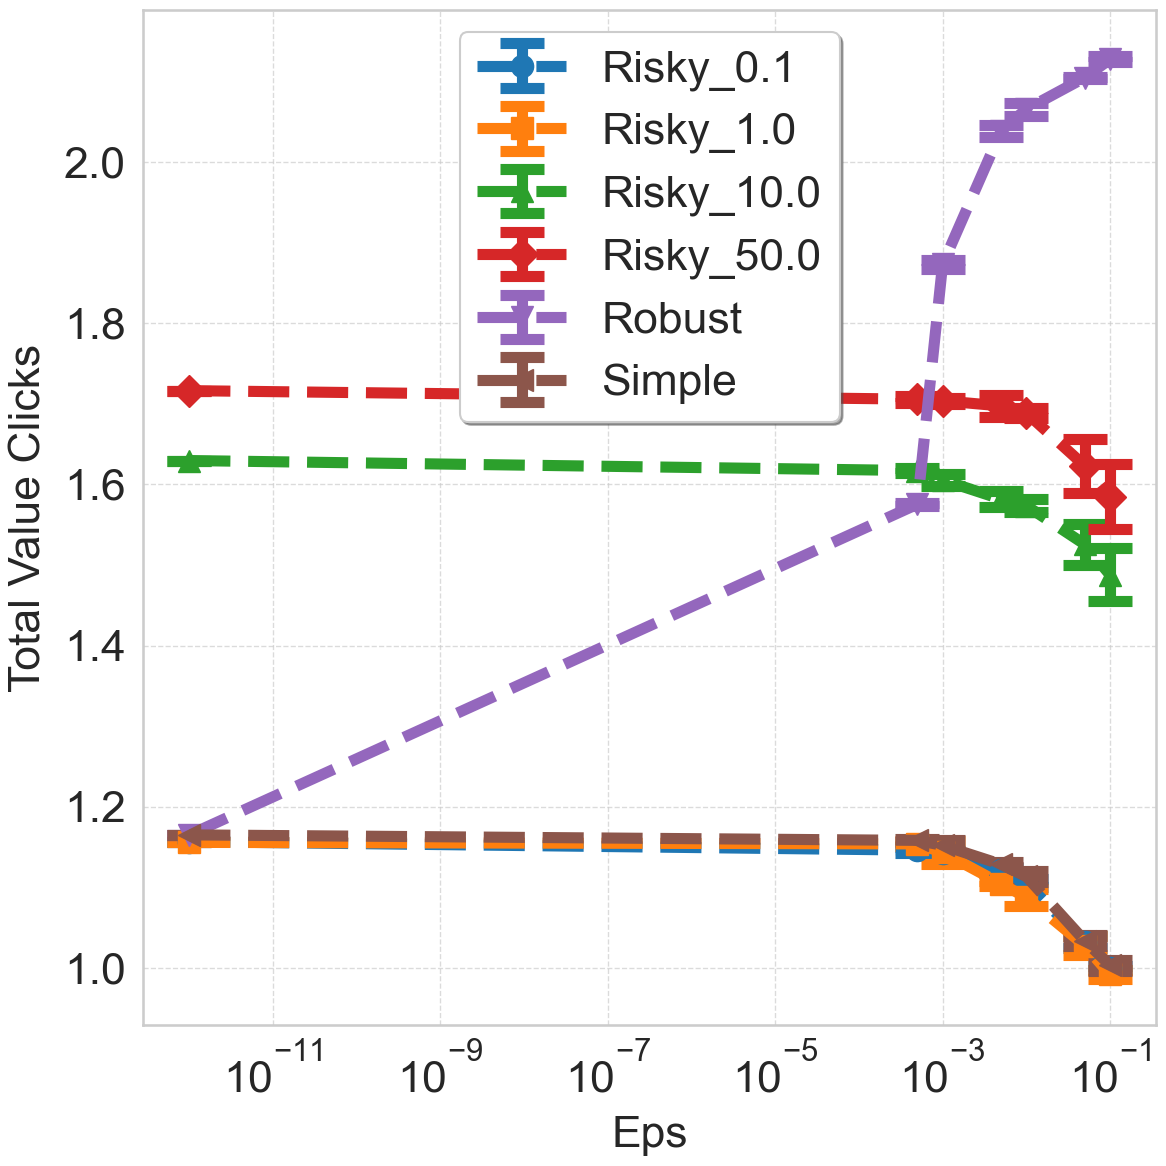

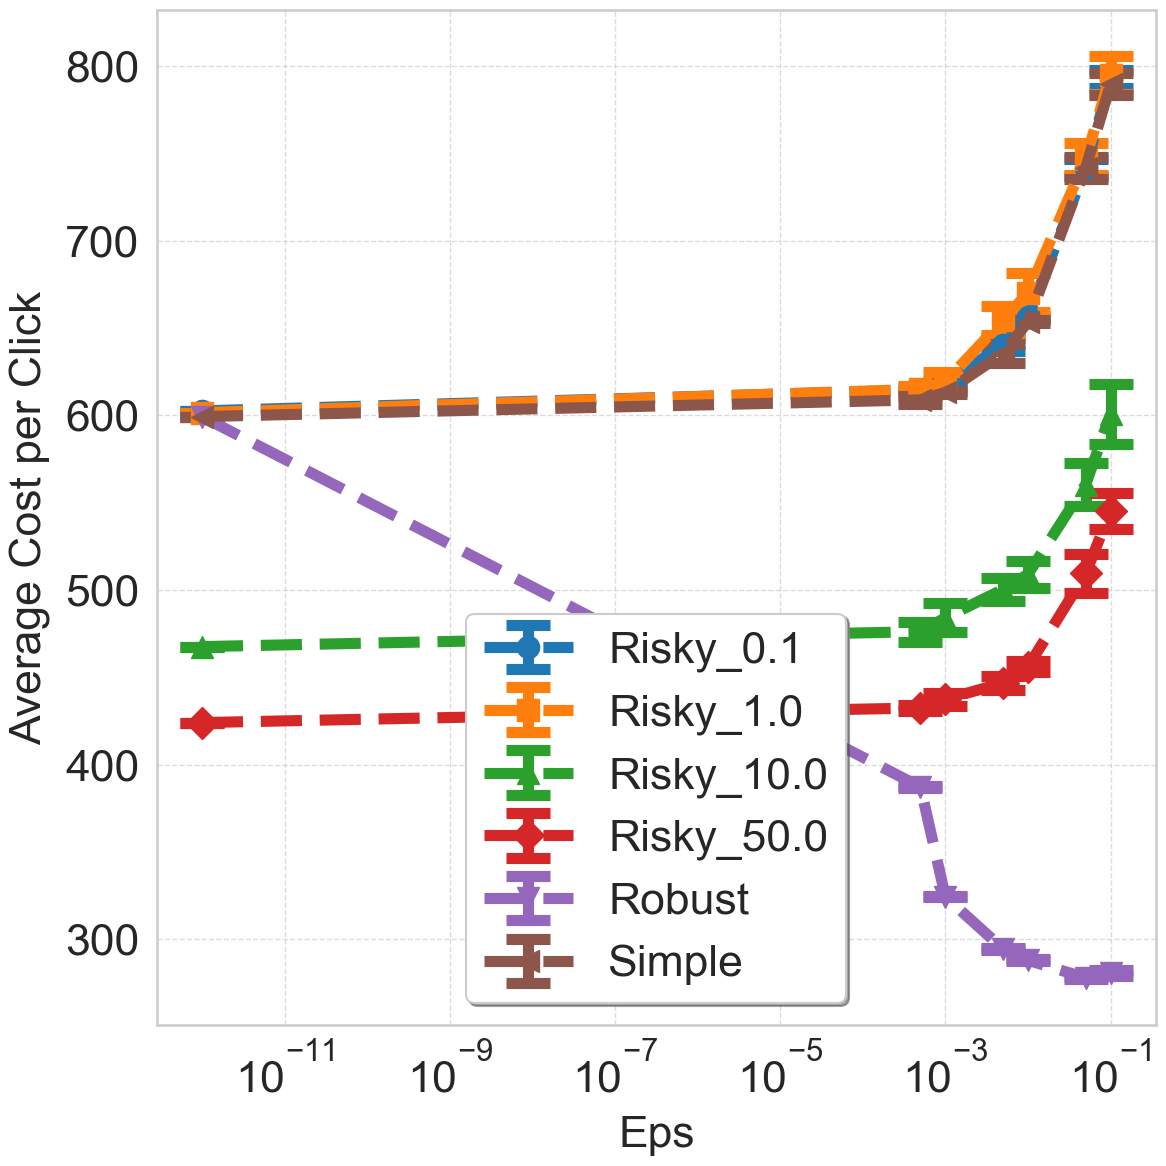

In [190]:
plot_metric_with_error_CTR(
    eps_set=eps_set,
    agg_metrics=agg_metrics,
    metric_mean_col='mean_tvc',
    metric_std_col='std_tvc',
    metric_name='TVC',
    y_label='Total Value Clicks',
    loss_type=loss_type
)

# plot_metric_with_error_CTR(
#     eps_set=eps_set,
#     agg_metrics=agg_metrics,
#     metric_mean_col='mean_cpc_percent',
#     metric_std_col='std_cpc_percent',
#     metric_name='CPC Percent',
#     y_label='Cost per Click (%)',
#     loss_type=loss_type
# )

plot_metric_with_error_CTR(
    eps_set=eps_set,
    agg_metrics=agg_metrics,
    metric_mean_col='mean_cpc_avg',
    metric_std_col='std_cpc_avg',
    metric_name='CPC Avg',
    y_label='Average Cost per Click',
    loss_type=loss_type
)
